In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [4]:
import os
os.getcwd()

'/Users/carlokrups/code/JensKlug/zillows_real_estate/notebooks'

In [5]:
df = pd.read_csv('../raw_data/HouseTS.csv')
df.head()

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Alpharetta
1,2012-04-30,61870.0,245000.0,40.723982,130.528256,22.0,29.0,56.0,69.0,89.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202421.064584,Atlanta-Sandy Springs-Alpharetta
2,2012-05-31,125500.0,217450.0,63.913043,119.919216,24.0,40.0,63.0,60.0,144.5,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202681.309539,Atlanta-Sandy Springs-Alpharetta
3,2012-06-30,153000.0,189900.0,81.598080,105.617353,34.0,46.0,50.0,57.0,126.0,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202998.603897,Atlanta-Sandy Springs-Alpharetta
4,2012-07-31,165500.0,154000.0,81.598080,83.921175,39.0,49.0,42.0,50.0,80.0,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,203781.903446,Atlanta-Sandy Springs-Alpharetta


In [6]:
df.info()
df.describe()
df.isnull().sum()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884092 entries, 0 to 884091
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          884092 non-null  object 
 1   median_sale_price             884092 non-null  float64
 2   median_list_price             884092 non-null  float64
 3   median_ppsf                   884092 non-null  float64
 4   median_list_ppsf              884092 non-null  float64
 5   homes_sold                    884092 non-null  float64
 6   pending_sales                 884092 non-null  float64
 7   new_listings                  884092 non-null  float64
 8   inventory                     884092 non-null  float64
 9   median_dom                    884092 non-null  float64
 10  avg_sale_to_list              884092 non-null  float64
 11  sold_above_list               884092 non-null  float64
 12  off_market_in_two_weeks       884092 non-nul

Index(['date', 'median_sale_price', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks', 'city', 'zipcode', 'year', 'bank', 'bus',
       'hospital', 'mall', 'park', 'restaurant', 'school', 'station',
       'supermarket', 'Total Population', 'Median Age', 'Per Capita Income',
       'Total Families Below Poverty', 'Total Housing Units', 'Median Rent',
       'Median Home Value', 'Total Labor Force', 'Unemployed Population',
       'Total School Age Population', 'Total School Enrollment',
       'Median Commute Time', 'price', 'city_full'],
      dtype='object')

In [ ]:
# Set data as index
df.set_index('date', inplace=True)

<Axes: title={'center': 'National Average Median Sale Price Over Time'}, xlabel='date'>

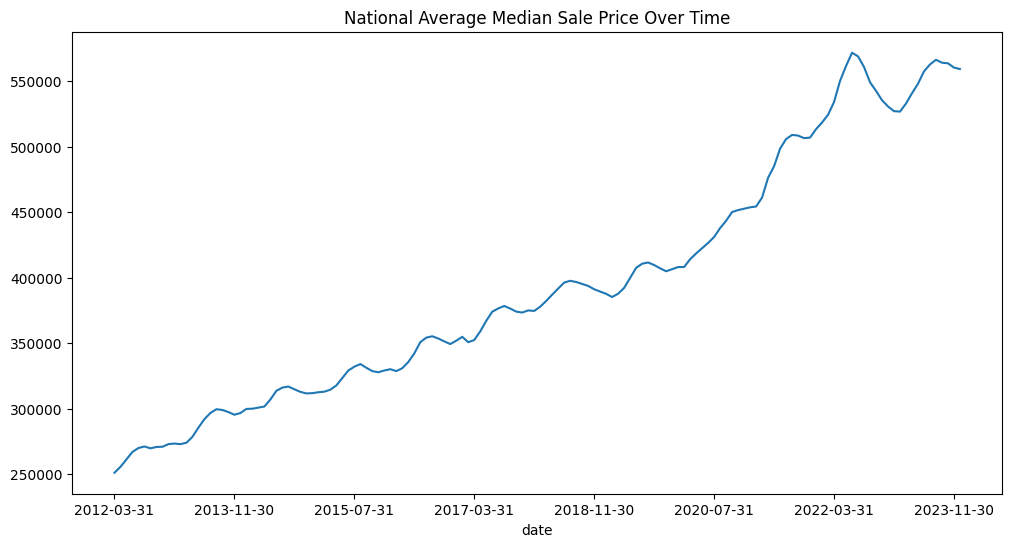

In [ ]:
# Median sale price over time
df.groupby(df.index)['median_sale_price'].mean().plot(figsize=(12, 6), title='National Average Median Sale Price Over Time')

<Axes: title={'center': 'NY Median Sale Price Over Time'}, xlabel='date'>

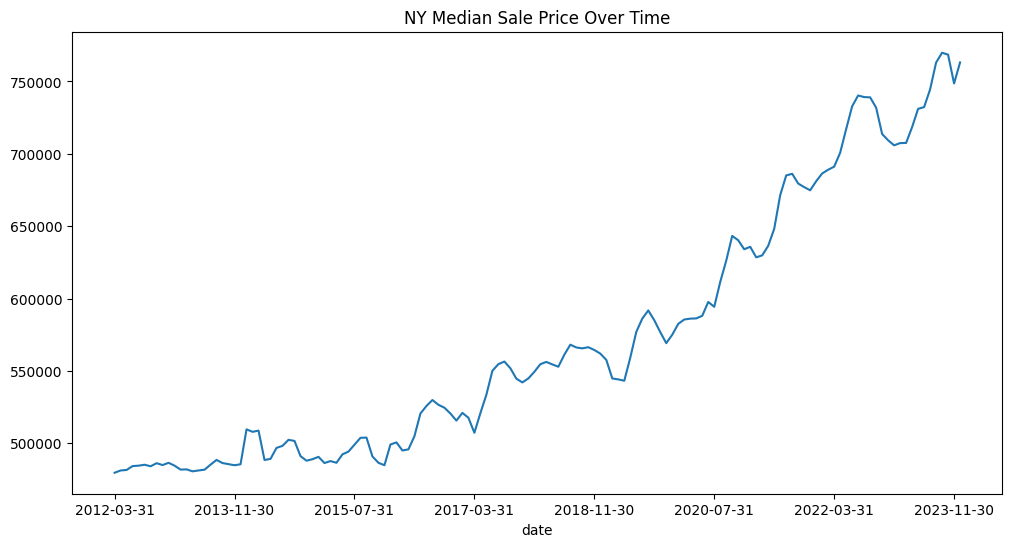

In [ ]:
# Median sale price over time for city
city_name = 'NY'
df_city = df[df['city'] == city_name]

df_city.groupby(df_city.index)['median_sale_price'].mean().plot(figsize=(12, 6), title=f'{city_name} Median Sale Price Over Time')

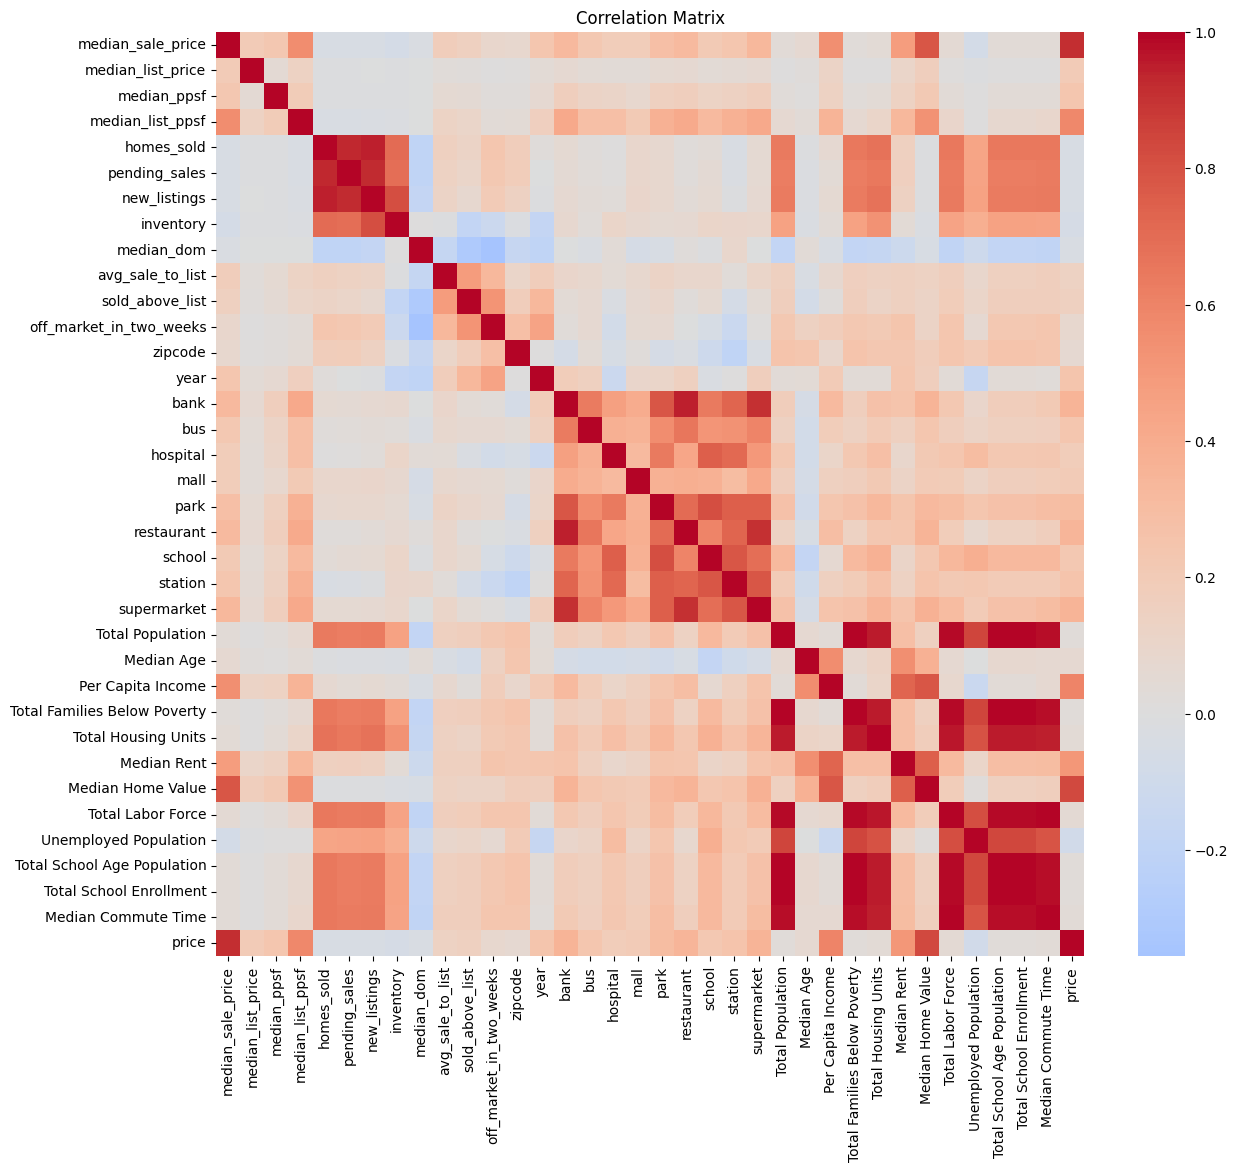

In [ ]:
# Heatmap for numerical features
plt.figure(figsize=(14, 12))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

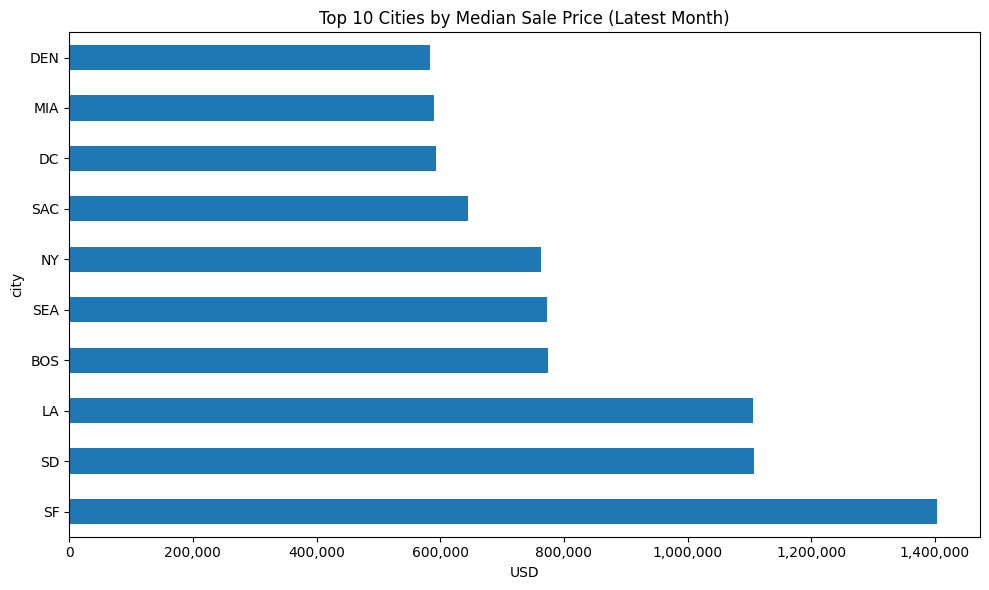

In [ ]:
# Top 10 cities by median sale price latest month
latest_date = df.index.max()
df_latest = df[df.index == latest_date]
top_cities_by_price = df_latest.groupby('city')['median_sale_price'].mean().sort_values(ascending=False).head(10)

ax = top_cities_by_price.plot(kind='barh', figsize=(10, 6), title='Top 10 Cities by Median Sale Price (Latest Month)', xlabel='USD')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

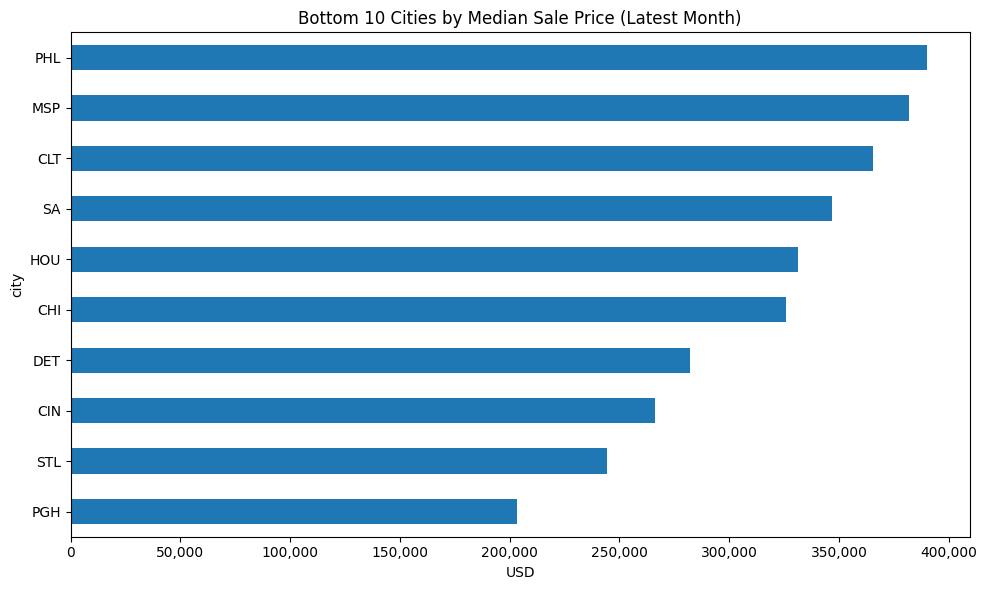

In [19]:
# Bottom 10 cities by median sale price latest month
latest_date = df.index.max()
df_latest = df[df.index == latest_date]
top_cities_by_price = df_latest.groupby('city')['median_sale_price'].mean().sort_values(ascending=True).head(10)

ax = top_cities_by_price.plot(kind='barh', figsize=(10, 6), title='Bottom 10 Cities by Median Sale Price (Latest Month)', xlabel='USD')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

In [23]:
# Compute correlation matrix for all numeric columns
correlation_matrix = df.select_dtypes(include='number').corr()
correlation_matrix_rounded = correlation_matrix.round(2)
print(correlation_matrix_rounded.to_string())

                              median_sale_price  median_list_price  median_ppsf  median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  median_dom  avg_sale_to_list  sold_above_list  off_market_in_two_weeks  zipcode  year  bank   bus  hospital  mall  park  restaurant  school  station  supermarket  Total Population  Median Age  Per Capita Income  Total Families Below Poverty  Total Housing Units  Median Rent  Median Home Value  Total Labor Force  Unemployed Population  Total School Age Population  Total School Enrollment  Median Commute Time  price
median_sale_price                          1.00               0.20         0.23              0.56       -0.04          -0.04         -0.04      -0.07       -0.02              0.18             0.16                     0.09     0.08  0.23  0.32  0.22      0.18  0.19  0.28        0.32    0.21     0.24         0.33              0.03        0.07               0.55                          0.03                 0.04         0.48      

In [29]:
df['zipcode'].value_counts()

zipcode
30002    142
32757    142
32811    142
32810    142
32809    142
        ... 
48069    142
48067    142
48066    142
48065    142
34698    142
Name: count, Length: 6226, dtype: int64